# Simple MNIST pytorch and rml example

First a little bit about rml:
```python
rml.train       # simple extendable functions to create/use training loops (and some other stuff)
rml.modules     # some pytorch modules (e.g. mlp -> for fully coonnected nets)
rml.utils. 
    annealing   # learning rate annealing stuff
    data        # splitting datasets / preloading data on GPU
    file        # downloading files
    generic     # random stuff
    metrics     # some metrics such as accuracy
    model       # freezing weights of layers, counting params, setting learning rates, loading/saving models
    plotting    # plotting images, lists, learning data etc...
    prediction  # utils for using models
    text        # utils for nlp
    vision      # utils for cv (just transformations)
    utils       # more or less options to set that affect the whole library
```

In [1]:
import rml as rml
import rml.utils as utils
import rml.training as train

import torch
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [2]:
%matplotlib inline
%load_ext autoreload

In [3]:
utils.utils.set_is_notebook(True)

In [4]:
to_tensor = tv.transforms.ToTensor()

def transform(x):
    x = to_tensor(x)
    x = x.view(-1)
    
    return x

In [5]:
train_ds = tv.datasets.MNIST("mnist", train=True, transform=transform)
test_ds = tv.datasets.MNIST("mnist", train=False, transform=transform)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128)

In [6]:
model = rml.modules.mlp.MLP([784, 512, 64, 10], out_activation=torch.nn.LogSoftmax(dim=-1))
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.NLLLoss()

Most usefull method in rml: train.optimize

```python
train.optimize(epochs: int,                             # for how many epochs to optimize
               model: torch.nn.Module,                  # model to optimze
               optimizer: torch.optim.Optimizer,        # which optimizer to use
               loss: LossCall,                          # loss to use
               train_dl: DataLoader,                    # data loader to get training data, any iterater will do actually
               valid_dl: DataLoader = None,             # same for validation data
               metric: MetricCall = None,               # metric to use for printing information; function taking prediction and target and returning some metric (some buildin in utils.metrics)
               feed_target: bool = False,               # whether to feed the target to the model together with the input (useful for some models)
               epoch_callback: EpochCallback = None,    # callback called after each epoch (epoch, epochs, model, progress_bar)
               step_callback: StepCallback = None,      # callback called after each step (step, steps, model, progress_bar, input, target, prediction, loss)
               print_results: bool = True,              # can be used to prevent printing info about train/test loss and metrics
               batch_dim: int = 0,                      # which dimension of the tensor stores the batch
               training_stepper=training_step,          # what function (cost, optimizer) to use to train the model (using rml.train.training_step by default); should perform one optimization step
               ittr_limit: int = None,                  # how many iterations to train for per epoch (defaults to all data, useful to lower if you want more evaluations of eval loss/metrics)
               lr_scheduler = None,                     # what kind of learning rate scheduler to use
               epoch_save_path: str = None,             # path to save the model to every epoch (if None, nothing is saved)
               basic_stepper = basic_step):             # which basic stepper (model, (input, target), loss, feed_target) to use (defaults to rml.train.basic_step); should make predicitons and calculate the loss
```

There also exists an `optimize_bare` function which is quite a bit quicker (although negligible for any somewhat larger model) but less informative

In [7]:
data = train.optimize(4, model, optim, loss, train_dl, test_dl, utils.metrics.accuracy, print_results=True) 


Epoch: 0


Train Cost: 0.3315500662620388
Test Cost: 0.14548443340330938
Metric: 0.9548

Epoch: 1


Train Cost: 0.1212894384747248
Test Cost: 0.09923081092913694
Metric: 0.9681

Epoch: 2


Train Cost: 0.0788806346036605
Test Cost: 0.0821382586337343
Metric: 0.9742

Epoch: 3


Train Cost: 0.05707126093317451
Test Cost: 0.07259844639633276
Metric: 0.9764



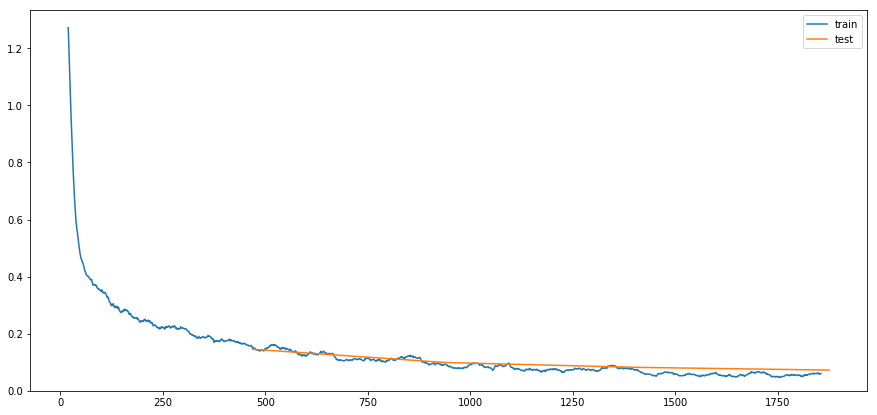

In [8]:
utils.plotting.plot_train_data(data)


Prediction:
tensor([[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1],
        [3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2],
        [4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3],
        [7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7],
        [7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4],
        [1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7],
        [3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5]])

Actual:


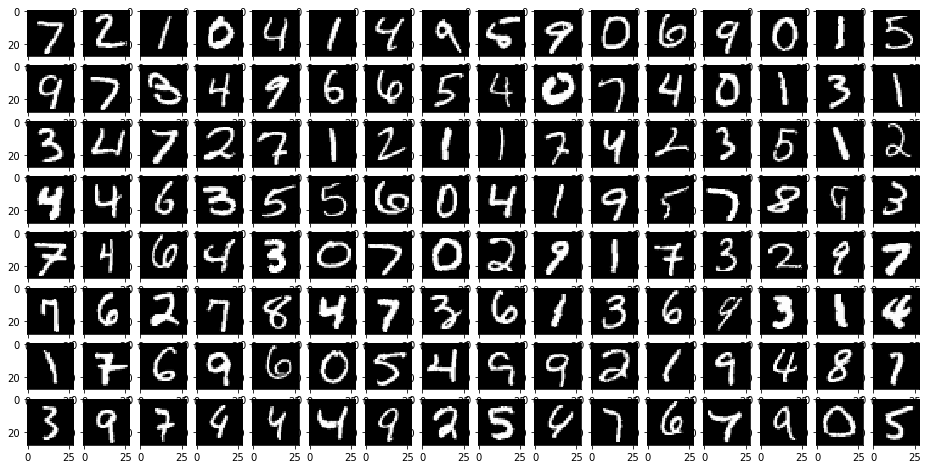

In [58]:
X, _ = next(iter(test_dl))

pred = utils.prediction.predict_many(model, X, bs=len(X))
pred = torch.argmax(pred, dim=-1)

print("Prediction:")
print(pred.view(8, 16))

ims = [tv.transforms.ToPILImage()(x) for x in X.view(128, 1, 28, 28)]
utils.plotting.disp_images(ims, rows=8, cols=16, im_height=1, im_width=1)

print("\nActual:")
plt.show()